<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/cnn/cnn_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.tensorflow.org/tutorials/keras/text_classification


In [8]:
import os
import re
import string
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, losses
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping


In [9]:
batch_size = 128
seed = 2021
max_features = 10000
sequence_length = 250
embedding_dim = 100
epochs = 100
earlystopping_patience = 10

In [10]:
# Get the raw dataset.

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = get_file("aclImdb_v1.tar.gz", url,  untar=True, cache_dir=".", cache_subdir="")
dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)
os.remove("aclImdb_v1.tar.gz.tar.gz")

raw_train_ds = text_dataset_from_directory(
    "aclImdb/train", 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="training", 
    seed=seed)

raw_val_ds = text_dataset_from_directory(
    "aclImdb/train", 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="validation", 
    seed=seed)

raw_test_ds = text_dataset_from_directory(
    "aclImdb/test", 
    batch_size=batch_size)

84131840/84125825 [==============================] - 4s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [11]:
# Prepare the dataset for training

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(stripped_html, "[%s]" % re.escape(string.punctuation), "")


def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience)

model = Sequential([
  Embedding(max_features + 1, embedding_dim),
  Dropout(0.2),
  GlobalAveragePooling1D(),
  Dropout(0.2),
  Dense(1)])

model.summary()

# Loss function and optimizer
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[earlystop_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000100   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,000,201
Trainable params: 1,000,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
157/157 [==============================] - 9s 51ms/step - loss: 0.6933 - binary_accuracy: 0.4981 -

In [13]:
# Evaluate the model

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

196/196 [==============================] - 8s 40ms/step - loss: 0.6931 - binary_accuracy: 0.5091
Loss:  0.693067729473114
Accuracy:  0.5090799927711487


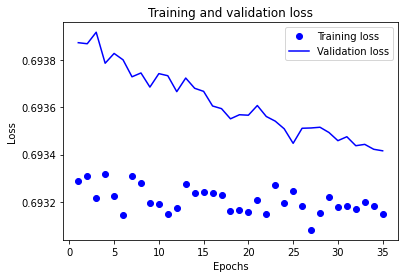

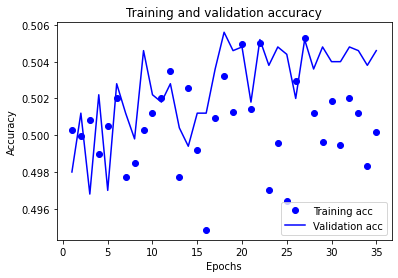

In [14]:
# Create a plot of accuracy and loss over time

history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Training and validation loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()